In [1]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
import astropy.units as u
from astropy.io import fits

import matplotlib
import matplotlib.colors as mcolors

from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

from mmtwfs.wfs import WFSFactory

from minicyclop.io import read_seeing_data

%load_ext autoreload
%autoreload 2
#%matplotlib widget

SMALLER_SIZE = 14
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

In [2]:
# instantiate all of the WFS systems...
wfs_keys = ['f9', 'newf9', 'f5', 'mmirs', 'binospec']
wfs_systems = {}
wfs_names = {}
for w in wfs_keys:
    wfs_systems[w] = WFSFactory(wfs=w)
    wfs_names[w] = wfs_systems[w].name

# give mmirs a default
wfs_systems['mmirs'].default_mode = 'mmirs1'

# map f9 to oldf9
wfs_systems['oldf9'] = wfs_systems['f9']

plt.close('all')

In [3]:
rootdir = Path("./data")
# use find to make this csv list
with open(rootdir / "reanalyze_csvs_all.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [4]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,318835,1,binospec,318835
f5,119074,1,f5,119074
mmirs,113240,1,mmirs,113240
newf9,5163,1,newf9,5163
oldf9,55482,1,oldf9,55482


In [19]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
#data['seeing'][data['seeing'].apply(isinstance, args=(str,))] = 0.0
fixed = data[[isinstance(x, float) for x in data['seeing']]]
fixed['seeing'] = fixed['seeing'].astype(float)
fixed['vlt_seeing'] = fixed['vlt_seeing'].astype(float)
fixed['airmass'] = fixed['airmass'].astype(float)
fixed = fixed[np.isfinite(fixed['seeing'])]
fixed = fixed[np.isfinite(fixed['vlt_seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['vlt_seeing'] > 0.2]
fixed = fixed[fixed['vlt_seeing'] < 4.]
fixed = fixed[np.isfinite(fixed['airmass'])]
fixed = fixed[fixed['exptime'] >= 5.]

/var/folders/vx/hkwj3_y50fgbdckq7hcv_p000000gn/T/ipykernel_6749/3925021138.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed['seeing'] = fixed['seeing'].astype(float)
/var/folders/vx/hkwj3_y50fgbdckq7hcv_p000000gn/T/ipykernel_6749/3925021138.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed['vlt_seeing'] = fixed['vlt_seeing'].astype(float)
/var/folders/vx/hkwj3_y50fgbdckq7hcv_p000000gn/T/ipykernel_6749/3925021138.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [13]:
fixed.to_csv(rootdir / "wfs_seeing_2003_2025.csv")

In [20]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

In [21]:
fixed['seeing'].median(), fixed['vlt_seeing'].median()

(1.02462932624136, 0.9443701100056532)

In [22]:
fixed.rename(columns={"seeing": "old_seeing", "vlt_seeing": "seeing"}, inplace=True)
fixed

,time,wfs,file,exptime,airmass,az,el,osst,outt,chamt,...,xcen,ycen,old_seeing,raw_seeing,seeing,raw_vlt_seeing,ellipticity,fwhm,wavefront_rms,residual_rms
ut,,,,,,,,,,,,,,,,,,,,,
2003-04-11 06:30:09.000,2003-04-11T06:30:09,oldf9,20030410_big_run2_0000.fits,20.0,1.0980,91.986000,65.593000,NaN,NaN,NaN,...,265.017402,266.006288,1.353409,1.353409,1.422668,1.422668,0.094692,9.487478,995.938037,3530.973987
2003-04-11 06:31:07.000,2003-04-11T06:31:07,oldf9,20030410_big_run2_0001.fits,30.0,1.0960,92.127000,65.798000,NaN,NaN,NaN,...,262.986527,268.007789,2.591381,2.591381,1.500692,1.500692,0.164622,15.410255,985.776541,3544.518859
2003-04-11 06:33:55.000,2003-04-11T06:33:55,oldf9,20030410_big_run3_0000.fits,10.0,1.0860,95.818000,67.068000,NaN,NaN,NaN,...,260.977237,268.011099,2.779571,2.779571,1.569749,1.569749,0.106498,16.282333,1201.963222,3757.614193
2003-04-11 06:34:38.000,2003-04-11T06:34:38,oldf9,20030410_big_run3_0001.fits,20.0,1.0850,95.949000,67.223000,NaN,NaN,NaN,...,265.015219,269.001050,2.492992,2.492992,1.456563,1.456563,0.099102,14.951399,1087.727533,3716.825567
2003-04-11 06:36:36.000,2003-04-11T06:36:36,oldf9,20030410_big_run3_0002.fits,20.0,1.0810,96.310000,67.640000,NaN,NaN,NaN,...,267.990316,261.997190,1.227307,1.227307,1.250367,1.250367,0.079189,8.868558,920.366011,3405.873287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-07 12:43:34.763,2025-02-07T12:43:34.763000,binospec,wfs_ff_cal_img_2025.02.07T124334.763.fits,40.0,1.1297,-85.755499,62.271536,8.3,8.39,8.1,...,253.987486,249.988629,0.910092,0.979182,0.856727,0.921765,0.358959,5.496632,294.264408,1247.468680
2025-02-07 12:44:17.996,2025-02-07T12:44:17.996000,binospec,wfs_ff_cal_img_2025.02.07T124417.996.fits,40.0,1.1313,-85.683658,62.124723,8.2,8.46,8.1,...,254.014387,250.016934,0.993854,1.070211,0.894945,0.963703,0.302897,5.851590,658.710220,1192.432145
2025-02-07 12:45:01.276,2025-02-07T12:45:01.276000,binospec,wfs_ff_cal_img_2025.02.07T124501.276.fits,40.0,1.1328,-85.613792,61.981332,8.2,8.10,8.0,...,255.003816,250.020985,0.824119,0.888141,0.769394,0.829164,0.401536,5.140685,227.342241,1144.396514


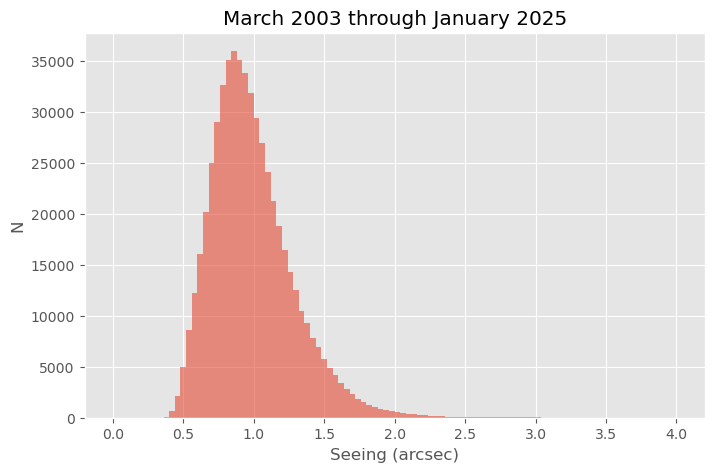

In [23]:
# make raw histogram of the zenith-corrected seeing column
#fixed.hist(column='seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    plt.hist(fixed['seeing'], bins=100, range=(0.0, 4.), alpha=0.6, label="no correction")
    plt.title("March 2003 through January 2025")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
plt.show()

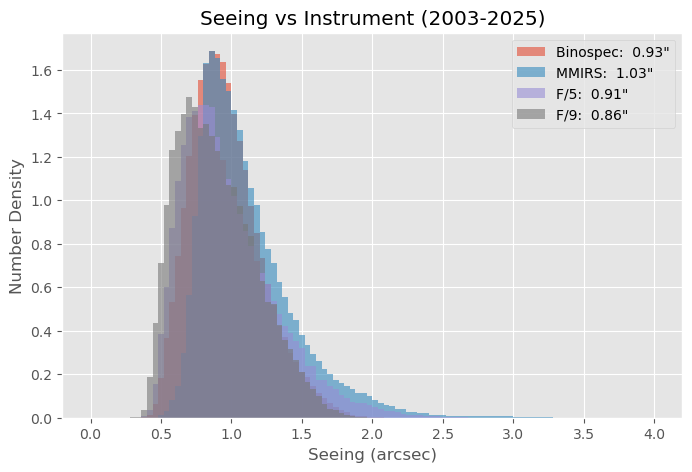

In [24]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    medb = np.median(fixed['seeing'][fixed['wfs'] == 'binospec'])
    medm = np.median(fixed['seeing'][fixed['wfs'] == 'mmirs'])
    med5 = np.median(fixed['seeing'][fixed['wfs'] == 'f5'])
    med9 = np.median(fixed['seeing'][(fixed['wfs'] == 'oldf9') | (fixed['wfs'] == 'newf9')])
    plt.hist(
        fixed['seeing'][fixed['wfs'] == 'binospec'],
        density=True,
        bins=100,
        range=(0.0, 4.),
        alpha=0.6,
        label=f"Binospec: {medb: .2f}\""
    )
    plt.hist(
        fixed['seeing'][fixed['wfs'] == 'mmirs'],
        density=True,
        bins=100,
        range=(0.0, 4.),
        alpha=0.6,
        label=f"MMIRS: {medm: .2f}\""
    )
    plt.hist(
        fixed['seeing'][fixed['wfs'] == 'f5'],
        density=True,
        bins=100,
        range=(0.0, 4.),
        alpha=0.6,
        label=f"F/5: {med5: .2f}\""
    )
    plt.hist(
        fixed['seeing'][(fixed['wfs'] == 'oldf9') | (fixed['wfs'] == 'newf9')],
        density=True,
        bins=100,
        range=(0.0, 4.),
        alpha=0.6,
        label=f"F/9: {med9: .2f}\""
    )
    plt.legend()
    plt.title("Seeing vs Instrument (2003-2025)")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
plt.savefig("all_bino_vs_mmirs_vs_f5_vs_f9.pdf")
plt.show()

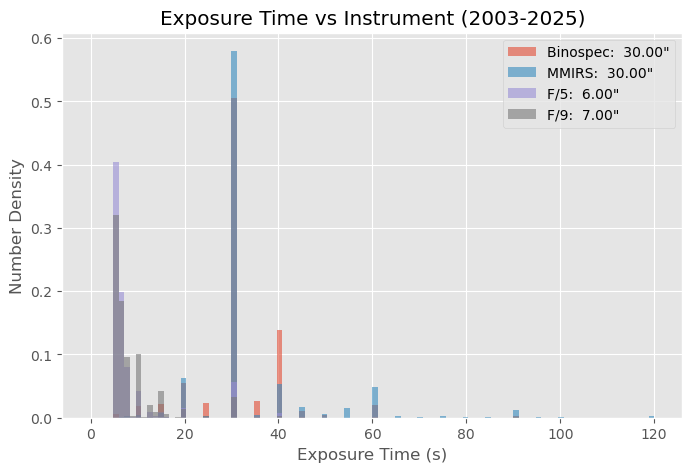

In [25]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(8, 5))
    medb = np.median(fixed['exptime'][fixed['wfs'] == 'binospec'])
    medm = np.median(fixed['exptime'][fixed['wfs'] == 'mmirs'])
    med5 = np.median(fixed['exptime'][fixed['wfs'] == 'f5'])
    med9 = np.median(fixed['exptime'][(fixed['wfs'] == 'oldf9') | (fixed['wfs'] == 'newf9')])
    plt.hist(
        fixed['exptime'][fixed['wfs'] == 'binospec'],
        density=True,
        bins=100,
        range=(0.0, 120.),
        alpha=0.6,
        label=f"Binospec: {medb: .2f}\""
    )
    plt.hist(
        fixed['exptime'][fixed['wfs'] == 'mmirs'],
        density=True,
        bins=100,
        range=(0.0, 120.),
        alpha=0.6,
        label=f"MMIRS: {medm: .2f}\""
    )
    plt.hist(
        fixed['exptime'][fixed['wfs'] == 'f5'],
        density=True,
        bins=100,
        range=(0.0, 120.),
        alpha=0.6,
        label=f"F/5: {med5: .2f}\""
    )
    plt.hist(
        fixed['exptime'][(fixed['wfs'] == 'oldf9') | (fixed['wfs'] == 'newf9')],
        density=True,
        bins=100,
        range=(0.0, 120.),
        alpha=0.6,
        label=f"F/9: {med9: .2f}\""
    )
    plt.legend()
    plt.title("Exposure Time vs Instrument (2003-2025)")
    plt.xlabel("Exposure Time (s)")
    plt.ylabel("Number Density")
plt.savefig("all_exptime_bino_vs_mmirs_vs_f5_vs_f9.pdf")
plt.show()

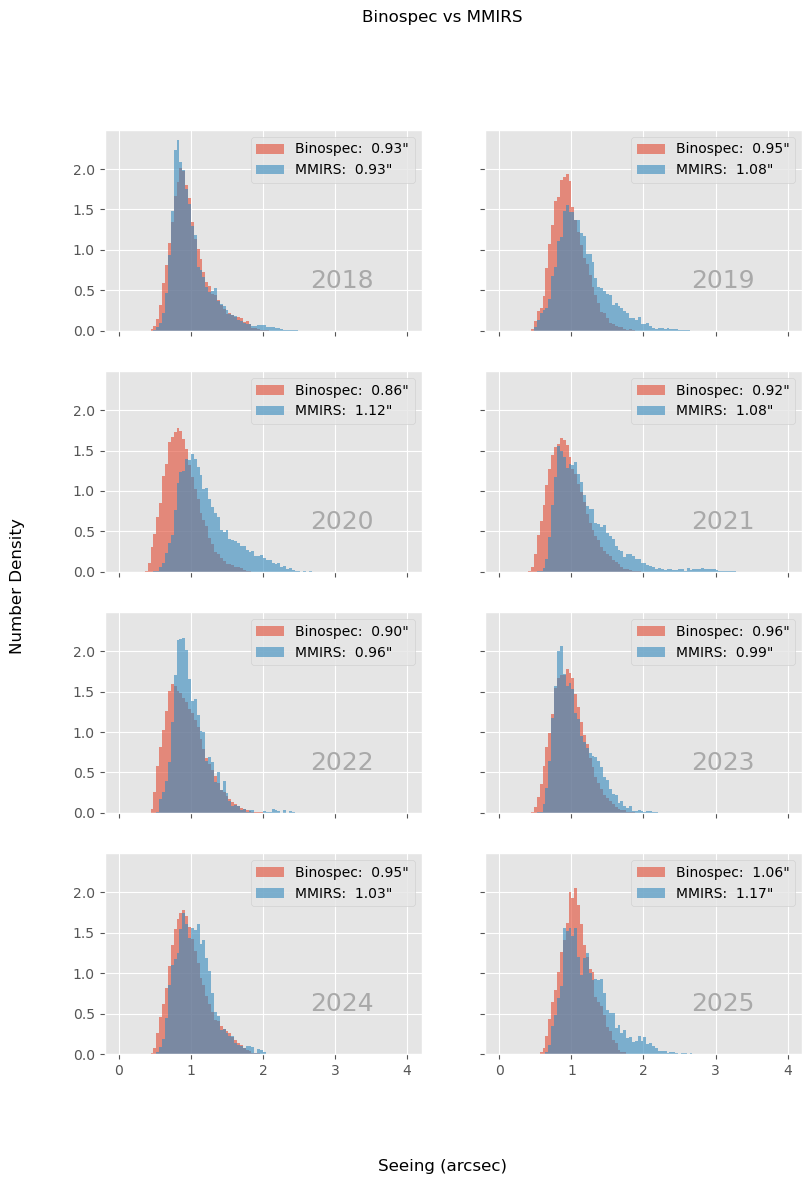

In [26]:
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(9, 12))
    fig.suptitle("Binospec vs MMIRS")
    fig.supylabel("Number Density")
    fig.supxlabel("Seeing (arcsec)")
    years = [str(y) for y in range(2018, 2026)]
    for ((i, year), ax) in zip(enumerate(years), axs.flat):
        year_df = fixed.loc[year]
        medb = np.median(year_df['seeing'][year_df['wfs'] == 'binospec'])
        medm = np.median(year_df['seeing'][year_df['wfs'] == 'mmirs'])
        ax.hist(
            year_df['seeing'][year_df['wfs'] == 'binospec'],
            density=True,
            bins=100,
            range=(0.0, 4.),
            alpha=0.6,
            label=f"Binospec: {medb: .2f}\""
        )
        ax.hist(
            year_df['seeing'][year_df['wfs'] == 'mmirs'],
            density=True,
            bins=100,
            range=(0.0, 4.),
            alpha=0.6,
            label=f"MMIRS: {medm: .2f}\""
        )
        ax.annotate(
            year,
            (0.75, 0.25),
            xycoords='axes fraction',
            ha='center',
            va='center',
            fontsize=18,
            color='darkgrey'
        )
        ax.legend()
plt.savefig("binospec_vs_mmirs_yearly.pdf")
plt.show()

In [27]:
fixed['seeing'][fixed['wfs'] == 'binospec'].median(), fixed['seeing'][fixed['wfs'] == 'mmirs'].median()

(0.9320700489895735, 1.0315610404597837)

In [28]:
# fit a log-normal distribution to the seeing data
seeing = np.array(fixed['seeing'], dtype=float)
seeing = seeing[np.isfinite(seeing)]
sigma, loc, exp_mu = lognorm.fit(seeing)
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.median(seeing)
fit_median = exp_mu + loc

0.32911611136000113 0.12630953466779418 0.8183308900601682


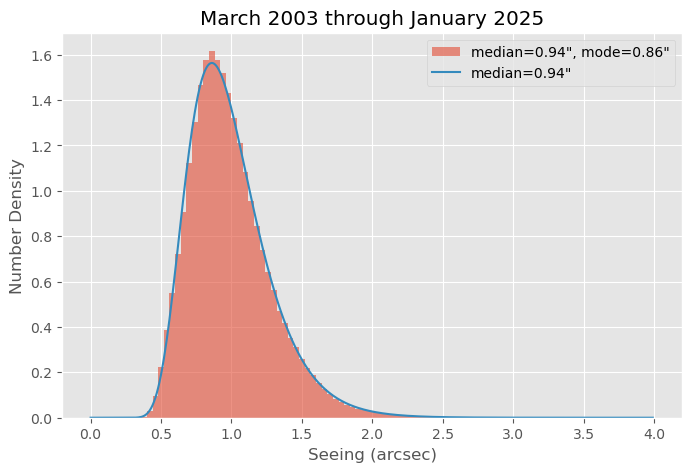

In [29]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    plt.hist(fixed['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title("March 2003 through January 2025")
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
    plt.savefig("all_hist.png")
    plt.savefig("all_hist.pdf")
plt.show()

In [30]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.nanmedian(first_half['seeing'])
med_2nd = np.nanmedian(second_half['seeing'])

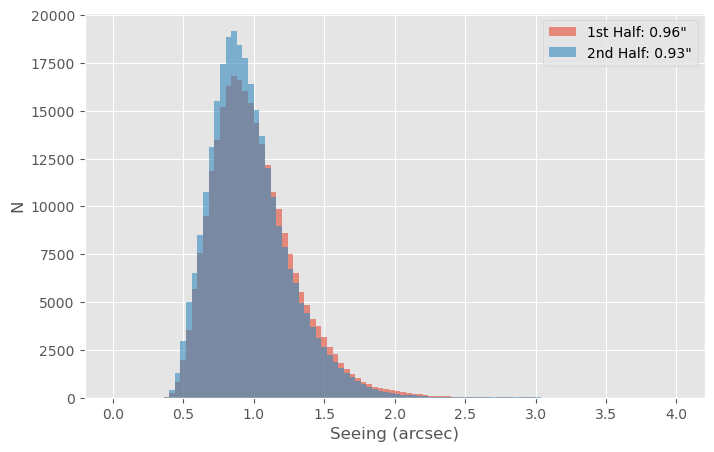

In [31]:
# plot the results and show that the seeing is better later in the night...
fig = plt.figure(figsize=(8, 5))
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("all_1st2nd.png")
plt.savefig("all_1st2nd.pdf")
plt.show()

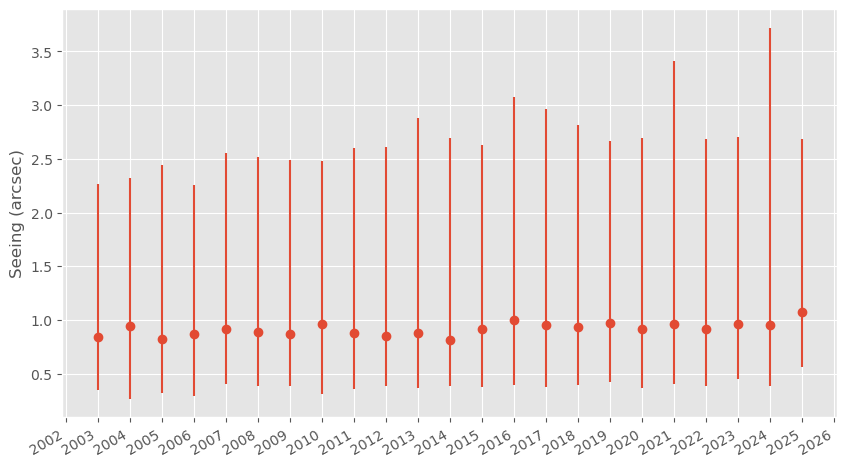

In [32]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots(figsize=(10, 6))
monthly = pd.DataFrame()
monthly['seeing'] = fixed.seeing.resample('Y', label='left').median()
monthly['max'] = fixed.seeing.resample('Y', label='left').max()
monthly['min'] = fixed.seeing.resample('Y', label='left').min()
lowb = monthly['seeing'] - monthly['min']
upb = monthly['max'] - monthly['seeing']
plt.errorbar(monthly.index, monthly['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("all_nightly.png")
plt.savefig("all_nightly.pdf")
plt.show()

In [33]:
year_list = [str(y) for y in range(2003, 2026)]
data = [np.array(fixed.loc[month]['seeing']) for month in year_list]
ellip_data = [np.array(fixed.loc[month]['ellipticity']) for month in year_list]
clean_data = {}
clean_ellip = {}
for d, arr in zip(year_list, data):
    if len(arr) > 0:
        clean_data[d] = arr[np.isfinite(arr)]
for d, arr in zip(year_list, ellip_data):
    if len(arr) > 0:
        clean_ellip[d] = arr[np.isfinite(arr)]
year_labels = [datetime.strptime(d, "%Y").date() for d in clean_data.keys()]
sizes = [len(clean_data[y]) for y in clean_data]
year_list

['2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022',
 '2023',
 '2024',
 '2025']

In [34]:
first_meds = []
sec_meds = []
for y in clean_data:
    year = fixed.loc[y]
    first_half = year.between_time(start_time='00:00', end_time='07:00')
    second_half = year.between_time(start_time='07:00', end_time='14:00')
    med_1st = np.nanmedian(first_half['seeing'])
    med_2nd = np.nanmedian(second_half['seeing'])
    first_meds.append(med_1st)
    sec_meds.append(med_2nd)
    print(f"{y}: {med_1st:.2f} {med_2nd:.2f}")

2003: 0.87 0.81
2004: 0.94 0.94
2005: 0.89 0.77
2006: 0.87 0.87
2007: 0.94 0.89
2008: 0.91 0.87
2009: 0.86 0.88
2010: 0.98 0.92
2011: 0.91 0.84
2012: 0.86 0.84
2013: 0.95 0.80
2014: 0.88 0.74
2015: 0.93 0.91
2016: 1.04 0.97
2017: 0.97 0.93
2018: 0.93 0.94
2019: 0.99 0.96
2020: 0.93 0.91
2021: 0.98 0.95
2022: 0.92 0.91
2023: 1.00 0.93
2024: 0.98 0.93
2025: 1.07 1.08


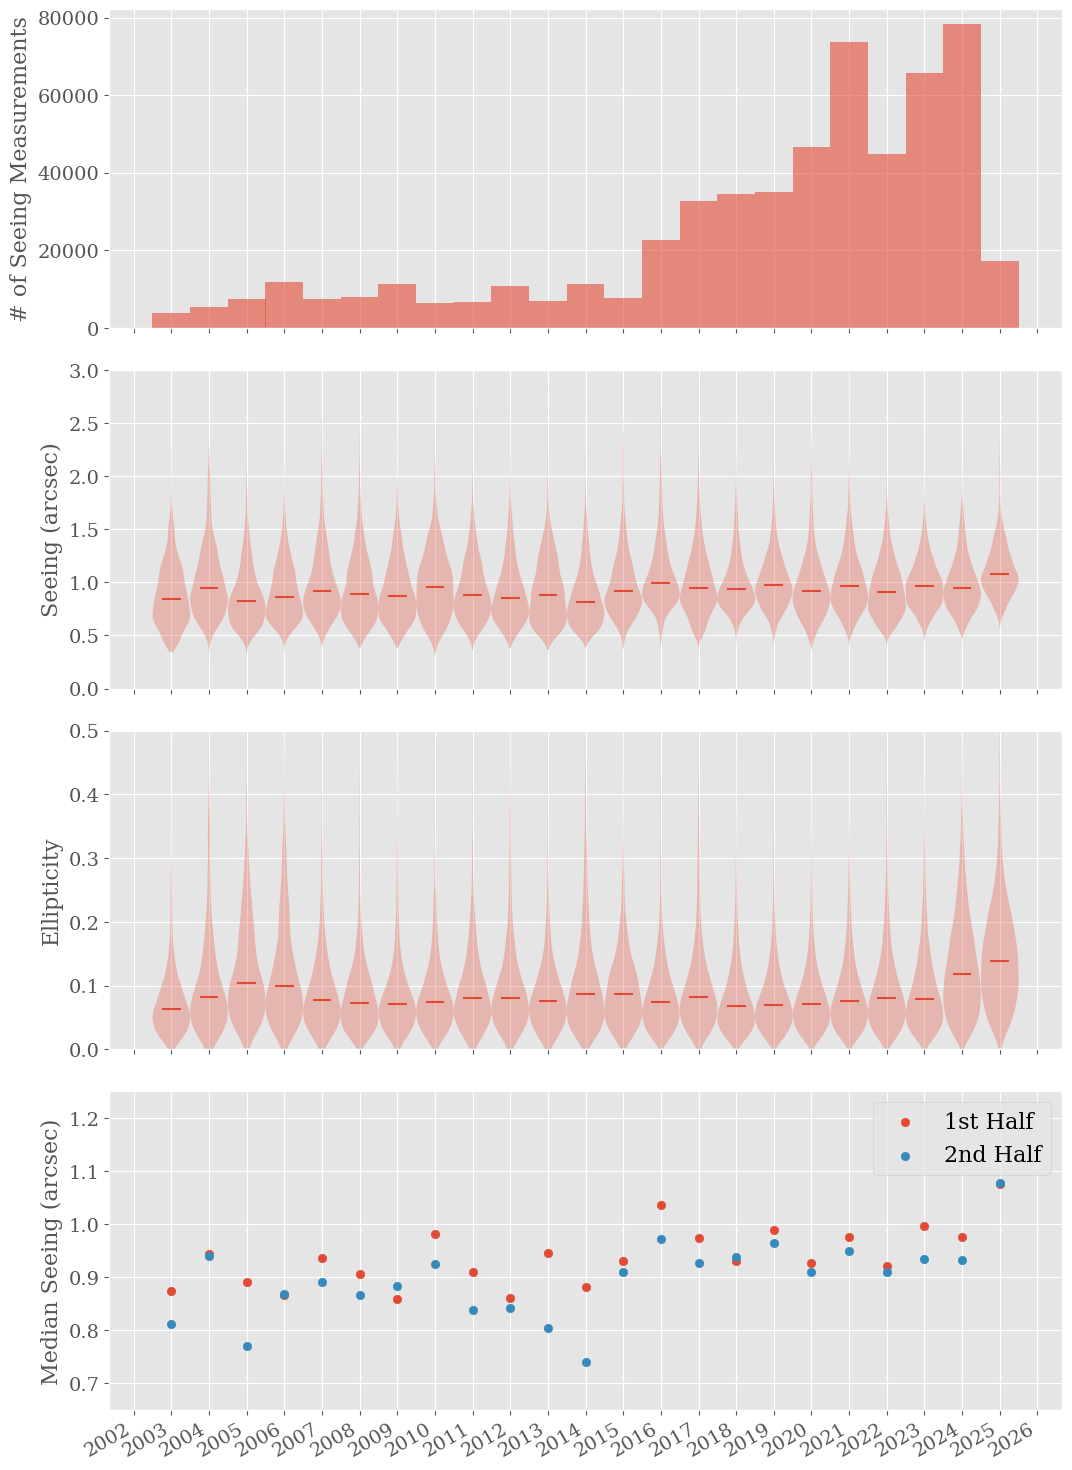

In [35]:
with plt.style.context('ggplot'):
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALLER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALLER_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
    fig, ax = plt.subplots(4, figsize=(11,15), sharex=True)
    ax[0].bar(mdates.date2num(year_labels), sizes, width=366, alpha=0.6)
    ax[0].set_ylabel("# of Seeing Measurements")
    ax[1].violinplot(clean_data.values(), mdates.date2num(year_labels), points=100, widths=365,
                showextrema=False, showmedians=True, bw_method='silverman')
    ax[1].set_ylim(0.0, 3.0)
    ax[1].set_ylabel("Seeing (arcsec)")
    ax[2].violinplot(clean_ellip.values(), mdates.date2num(year_labels), points=100, widths=365,
                showextrema=False, showmedians=True, bw_method='silverman')
    ax[2].set_ylim(0.0, 0.5)
    ax[2].set_ylabel("Ellipticity")
    ax[3].scatter(mdates.date2num(year_labels), first_meds, label="1st Half")
    ax[3].scatter(mdates.date2num(year_labels), sec_meds, label="2nd Half")
    ax[3].legend(frameon=True, fancybox=True)
    ax[3].set_ylim(0.65, 1.25)
    ax[3].set_ylabel("Median Seeing (arcsec)")
    ax[3].xaxis.set_major_locator(mdates.YearLocator())
    ax[3].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.savefig("all_violin.png")
    plt.savefig("all_violin.pdf")
    plt.show()

In [36]:
[len(clean_data[y]) for y in clean_data]

[3964,
 5270,
 7391,
 11717,
 7432,
 7945,
 11269,
 6554,
 6659,
 10807,
 6977,
 11279,
 7754,
 22703,
 32671,
 34481,
 34999,
 46730,
 73711,
 44800,
 65711,
 78210,
 17322]

In [37]:
diff = fixed['osst'] - fixed['outt']
trim_seeing = fixed['seeing'][np.abs(diff) < 100]
diff = diff[np.abs(diff) < 100]

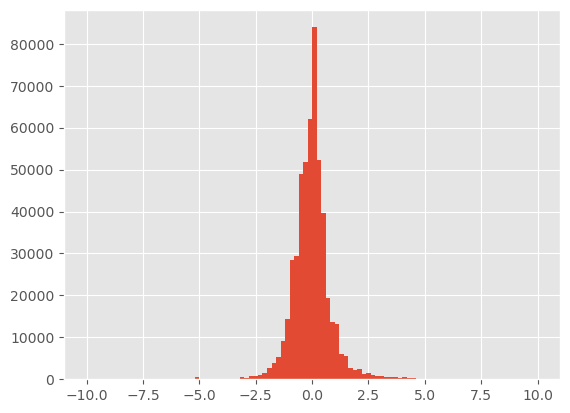

In [38]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots()
    ax.hist(diff, bins=100, range=(-10, 10))
plt.show()

In [39]:
temps = list(range(-3,6))
t_meds = []
for t in temps:
    seeing_slice = trim_seeing[(diff >= t-0.5) & (diff <= t+0.5)]
    t_meds.append(np.median(seeing_slice))
t_meds, temps

([np.float64(1.009724633608419),
  np.float64(0.980887195515484),
  np.float64(0.927683776717214),
  np.float64(0.9358511073671874),
  np.float64(0.9990452445575602),
  np.float64(1.0769454232931248),
  np.float64(1.139745073476432),
  np.float64(1.1643320914037885),
  np.float64(1.2318989481042464)],
 [-3, -2, -1, 0, 1, 2, 3, 4, 5])

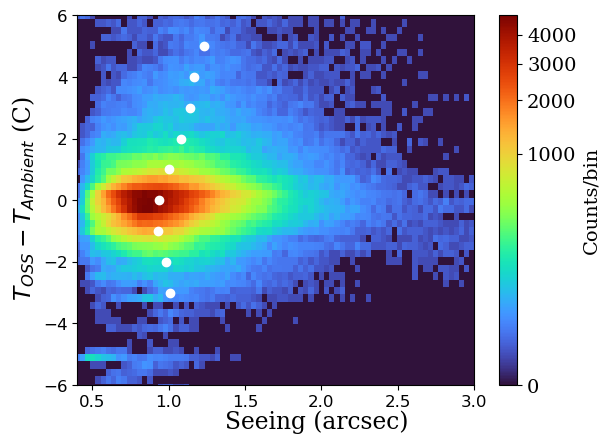

In [40]:
with plt.style.context('default'):
    fig, ax = plt.subplots()
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    h = ax.hist2d(trim_seeing, diff, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    fig.supxlabel("Seeing (arcsec)")
    fig.supylabel("$T_{OSS} - T_{Ambient}$ (C)")
    cb = fig.colorbar(h[-1])
    cb.set_label("Counts/bin")
    ax.set_ybound(-6, 6)
    ax.set_xbound(0.4, 3.0)
    ax.scatter(t_meds, temps, color='w')
    ax.tick_params(axis='both', labelsize=12)

plt.savefig("seeing_tempdiff.png")
plt.savefig("seeing_tempdiff.pdf")
plt.show()

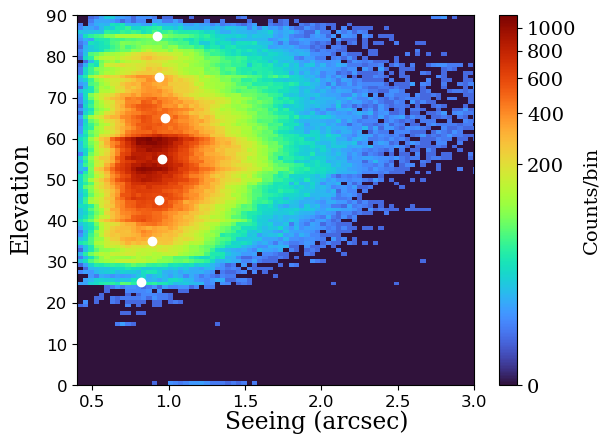

In [41]:
trimmed = fixed[np.isfinite(fixed['seeing'].astype(float)) & np.isfinite(fixed['el'].astype(float))]
trim_el = trimmed['el'].astype(float)
el_seeing = trimmed['seeing'].astype(float)
els = [25, 35, 45, 55, 65, 75, 85]
e_meds = []
for el in els:
    seeing_slice = el_seeing[(trim_el >= el-5) & (trim_el <= el+5)]
    e_meds.append(np.median(seeing_slice))
with plt.style.context('default'):
    fig, ax = plt.subplots()
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    h = ax.hist2d(el_seeing, trim_el, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    fig.supxlabel("Seeing (arcsec)")
    fig.supylabel("Elevation")
    cb = fig.colorbar(h[-1])
    cb.set_label("Counts/bin")
    plt.scatter(e_meds, els, color='w')
    ax.set_xbound(0.4, 3.0)
    ax.tick_params(axis='both', labelsize=12)

plt.savefig("seeing_elevation.png")
plt.savefig("seeing_elevation.pdf")
plt.show()

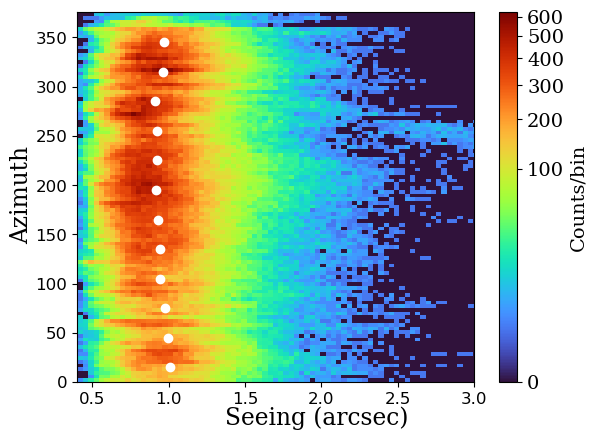

In [42]:
trimmed = fixed[np.isfinite(fixed['seeing'].astype(float)) & np.isfinite(fixed['az'].astype(float))]
trim_az = trimmed['az'].astype(float)
trim_az[trim_az < 0] += 360.
az_seeing = trimmed['seeing'].astype(float)
azs = [15, 45, 75, 105, 135, 165, 195, 225, 255, 285, 315, 345]
a_meds = []
for az in azs:
    seeing_slice = az_seeing[(trim_az >= az-15) & (trim_az <= az+15)]
    a_meds.append(np.median(seeing_slice))
with plt.style.context('default'):
    fig, ax = plt.subplots()
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    h = ax.hist2d(az_seeing, trim_az, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    fig.supxlabel("Seeing (arcsec)")
    fig.supylabel("Azimuth")
    cb = fig.colorbar(h[-1])
    cb.set_label("Counts/bin")
    ax.scatter(a_meds, azs, color='w')
    ax.set_xbound(0.4, 3.0)
    ax.tick_params(axis='both', labelsize=12)

plt.savefig("seeing_azimuth.png")
plt.savefig("seeing_azimuth.pdf")
plt.show()

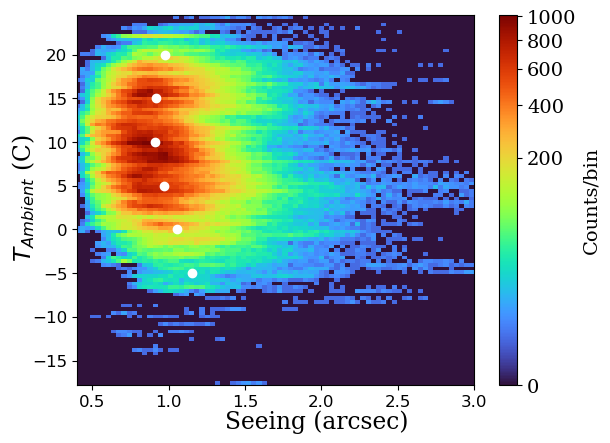

In [43]:
trimmed = fixed[np.isfinite(fixed['seeing'].astype(float)) & np.isfinite(fixed['outt'].astype(float))]
trim_outt = trimmed['outt'].astype(float)
outt_seeing = trimmed['seeing'].astype(float)
temps = list(range(-5, 25, 5))
temps_meds = []
for t in temps:
    seeing_slice = outt_seeing[(trim_outt >= t-2.5) & (trim_outt <= t+2.5)]
    temps_meds.append(np.median(seeing_slice))
with plt.style.context('default'):
    fig, ax = plt.subplots()
    plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
    plt.rc('font', family='serif')
    h = ax.hist2d(outt_seeing, trim_outt, bins=100, cmap='turbo', norm=mcolors.PowerNorm(0.3))
    fig.supxlabel("Seeing (arcsec)")
    fig.supylabel("$T_{Ambient}$ (C)")
    cb = fig.colorbar(h[-1])
    cb.set_label("Counts/bin")
    ax.scatter(temps_meds, temps, color='w')
    ax.set_xbound(0.4, 3.0)
    ax.tick_params(axis='both', labelsize=12)

plt.savefig("seeing_ambient.pdf")
plt.savefig("seeing_ambient.png")
plt.show()

In [44]:
from minicyclop.io import read_seeing_data
cyc = read_seeing_data(Path.home() / "MMT/minicyclop/data/MiniCyclop/Data/Seeing_Data.txt")
cyc.drop('UT', axis=1, inplace=True)
cyc

,flux,seeing,r0,isot,epoch_ms
ut,,,,,
2022-06-08 03:32:32,2733.7,0.84,135.8,2022-06-08T03:32:32.968,1654659152968
2022-06-08 03:33:27,2755.7,0.84,134.4,2022-06-08T03:33:27.409,1654659207408
2022-06-08 03:34:23,2801.6,2.38,47.7,2022-06-08T03:34:23.655,1654659263655
2022-06-08 03:35:16,2853.2,1.01,112.3,2022-06-08T03:35:16.325,1654659316324
2022-06-08 03:36:00,2739.0,1.03,110.7,2022-06-08T03:36:00.691,1654659360691
...,...,...,...,...,...
2025-02-08 06:37:28,1560.5,0.82,137.7,2025-02-08T06:37:28.007,1738996648007
2025-02-08 06:38:14,1484.8,0.62,183.9,2025-02-08T06:38:14.421,1738996694421
2025-02-08 06:39:00,1549.0,0.79,144.3,2025-02-08T06:39:00.913,1738996740912


In [45]:
fixed_overlap = fixed[fixed.index >= "2022-06-08"]

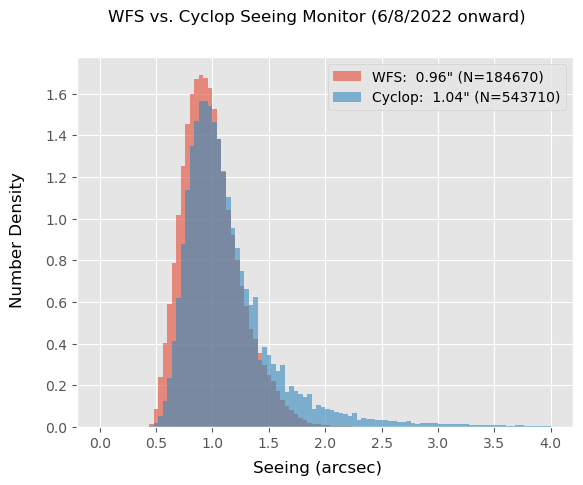

In [46]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots()
    med_wfs = np.median(fixed_overlap['seeing'])
    med_cyc = np.median(cyc['seeing'])
    w = ax.hist(
        fixed_overlap['seeing'],
        density=True,
        bins=100,
        range=(0.0, 4.0),
        label=f"WFS: {med_wfs: .2f}\" (N={len(fixed_overlap)})",
        alpha=0.6
    )
    c = ax.hist(
        cyc['seeing'],
        density=True,
        bins=100,
        range=(0.0, 4.0),
        label=f"Cyclop: {med_cyc: .2f}\" (N={len(cyc)})",
        alpha=0.6
    )
    fig.supxlabel("Seeing (arcsec)")
    fig.supylabel("Number Density")
    fig.suptitle("WFS vs. Cyclop Seeing Monitor (6/8/2022 onward)")
    ax.legend()
plt.savefig("wfs_cyclop.pdf")
plt.savefig("wfs_cyclop.png")
plt.show()

In [47]:
f9 = fixed_overlap[fixed_overlap['wfs'] == 'newf9']
bino = fixed_overlap[fixed_overlap['wfs'] == 'binospec']
hecto = fixed_overlap[fixed_overlap['wfs'] == 'f5']
mmirs = fixed_overlap[fixed_overlap['wfs'] == 'mmirs']

In [48]:
f9_dates = sorted(list(set(f9.index.strftime('%Y-%m-%d'))))
bino_dates = sorted(list(set(bino.index.strftime('%Y-%m-%d'))))
hecto_dates = sorted(list(set(hecto.index.strftime('%Y-%m-%d'))))
mmirs_dates = sorted(list(set(mmirs.index.strftime('%Y-%m-%d'))))
bino_dates, hecto_dates, f9_dates, mmirs_dates

(['2022-07-06',
  '2022-07-07',
  '2022-07-08',
  '2022-07-11',
  '2022-08-30',
  '2022-08-31',
  '2022-09-24',
  '2022-09-25',
  '2022-09-26',
  '2022-09-27',
  '2022-09-28',
  '2022-10-01',
  '2022-10-03',
  '2022-10-04',
  '2022-10-06',
  '2022-10-25',
  '2022-10-26',
  '2022-10-27',
  '2022-10-28',
  '2022-10-29',
  '2022-10-30',
  '2022-10-31',
  '2022-12-15',
  '2022-12-16',
  '2022-12-17',
  '2022-12-19',
  '2022-12-20',
  '2022-12-21',
  '2022-12-22',
  '2022-12-23',
  '2022-12-24',
  '2022-12-26',
  '2022-12-27',
  '2023-01-11',
  '2023-01-12',
  '2023-01-13',
  '2023-01-14',
  '2023-01-21',
  '2023-01-22',
  '2023-01-23',
  '2023-01-25',
  '2023-01-26',
  '2023-01-27',
  '2023-01-28',
  '2023-01-29',
  '2023-01-31',
  '2023-02-17',
  '2023-03-09',
  '2023-03-10',
  '2023-03-11',
  '2023-03-13',
  '2023-03-14',
  '2023-03-15',
  '2023-03-25',
  '2023-03-26',
  '2023-03-27',
  '2023-03-28',
  '2023-03-29',
  '2023-03-30',
  '2023-04-12',
  '2023-04-13',
  '2023-04-14',
  '2023-

In [49]:
cyc_f9 = np.hstack([np.array(cyc.loc[date]['seeing']) for date in f9_dates])
cyc_bino = np.hstack([np.array(cyc.loc[date]['seeing']) for date in bino_dates])
cyc_hecto = np.hstack([np.array(cyc.loc[date]['seeing']) for date in hecto_dates])
cyc_mmirs = np.hstack([np.array(cyc.loc[date]['seeing']) for date in mmirs_dates])

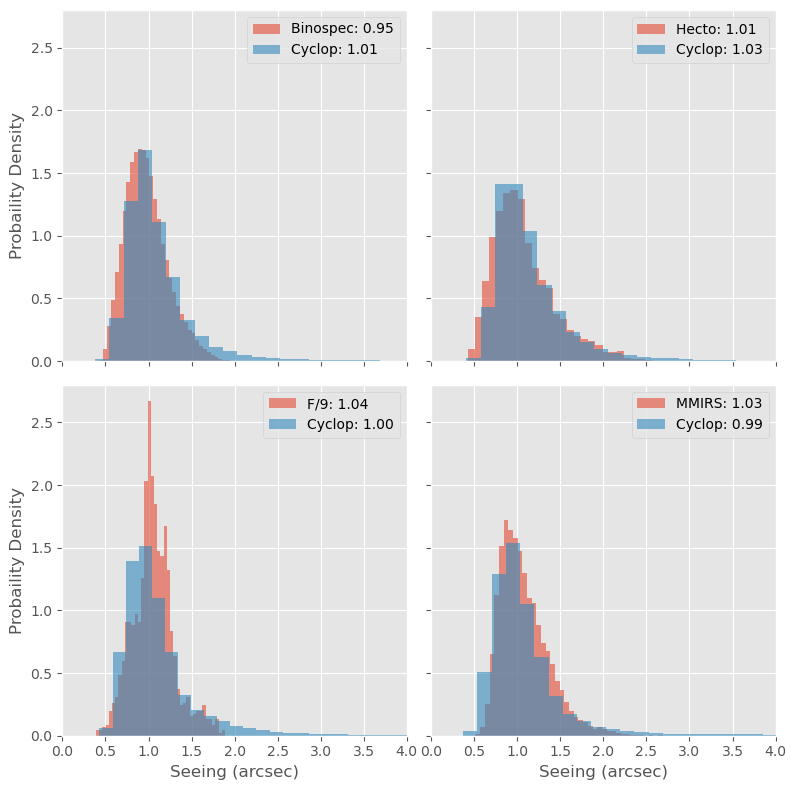

In [50]:
with plt.style.context('ggplot', after_reset=False):
    fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
    ax = ax.flat
    fig.subplots_adjust(hspace=0)

    bin_type = 40

    ax[0].hist(bino['seeing'], bins=bin_type, histtype='stepfilled', alpha=0.6, density=True)
    ax[0].hist(cyc_bino, bins=bin_type, histtype='stepfilled', alpha=0.6, density=True)
    ax[0].legend([f"Binospec: {np.median(bino['seeing']):.2f}", f"Cyclop: {np.median(cyc_bino):.2f}"])
    ax[0].set_ylabel("Probaility Density")
    ax[0].set_xlim(0, 4)

    ax[1].hist(hecto['seeing'], bins=bin_type, histtype='stepfilled', alpha=0.6, density=True)
    ax[1].hist(cyc_hecto, bins=bin_type, histtype='stepfilled', alpha=0.6, density=True)
    ax[1].legend([f"Hecto: {np.median(hecto['seeing']):.2f}", f"Cyclop: {np.median(cyc_hecto):.2f}"])
    ax[1].set_xlim(0, 4)

    ax[2].hist(f9['seeing'], bins=bin_type, histtype='stepfilled', alpha=0.6, density=True)
    ax[2].hist(cyc_f9, bins=bin_type, histtype='stepfilled', alpha=0.6, density=True)
    ax[2].legend([f"F/9: {np.median(f9['seeing']):.2f}", f"Cyclop: {np.median(cyc_f9):.2f}"])
    ax[2].set_xlim(0, 4)
    ax[2].set_xlabel("Seeing (arcsec)")
    ax[2].set_ylabel("Probaility Density")

    ax[3].hist(mmirs['seeing'], bins=bin_type, histtype='stepfilled', alpha=0.6, density=True)
    ax[3].hist(cyc_mmirs, bins=bin_type, histtype='stepfilled', alpha=0.6, density=True)
    ax[3].legend([f"MMIRS: {np.median(mmirs['seeing']):.2f}", f"Cyclop: {np.median(cyc_mmirs):.2f}"])
    ax[3].set_xlim(0, 4)
    ax[3].set_xlabel("Seeing (arcsec)")

    plt.tight_layout()
    plt.savefig("all_cyclop_vs_inst.png")
    plt.show()